In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

import sys
import os
import time
import numpy as n

from collections import OrderedDict
import time
import gc

Populating the interactive namespace from numpy and matplotlib


In [23]:
qdemod_basepath =  '/home/ali/Documents/UTAT/GNURadio/2018-12-22/es_bcn_quaddemod_lpf_'
lpf1 = [100.0, 50.0, 30.0, 10.0]
lpf2 = [10.0, 20.0]
recordings = {}
recordings_raw = {}
for l1 in lpf1:
    for l2 in lpf2:
        recordings_raw[str(l1)+'_'+str(l2)] = n.fromfile(qdemod_basepath+str(l1)+'lpf2_'+str(l2) , dtype=n.float32)

In [4]:
def find_all(a_str, sub):
    res = []
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return res
        res.append(start)
        start += len(sub) # use start += 1 to find overlapping matches


In [50]:
def correlate_strings(a,b):
    assert len(a) == len(b)
    str_len = len(a)
    s = 0
    for i in range(str_len):
        if a[i] == b[i]: s+=1
    return s*1.0/(str_len*1.0)

In [5]:
def secs_to_sample(seconds): return n.int(seconds/period)

In [28]:
transmission_start = 0.08
transmission_end = 0.125
for k,v in recordings_raw.iteritems():
    recordings[k] = v[secs_to_sample(transmission_start):secs_to_sample(transmission_end)]

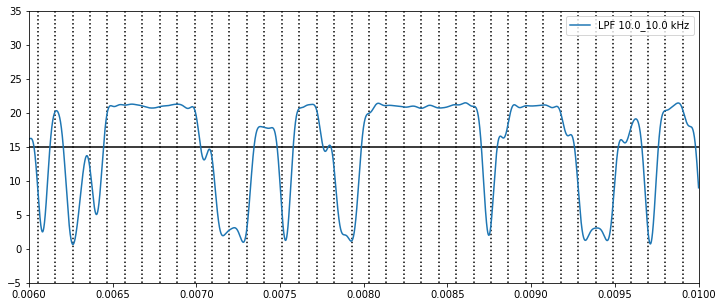

In [45]:
n_samples = recordings[recordings.keys()[0]].shape[0]
sample_rate = 4.0032e6
period = 1.0/sample_rate

baudrate = 9600
baud_period = 1.0/float(baudrate)

fig = plt.figure(figsize=(12,5))
ts = n.arange(0, period * n_samples, period)



start = 0
stop = n_samples
for l1 in [10.0]:
    for l2 in [10.0]:
        lpf = str(l1) + '_' + str(l2)

        plot(ts[start:stop],recordings[lpf][start:stop], label="LPF " + str(lpf) + " kHz")

phase_delay = 0.1
for i in range(int((n_samples*period)/baud_period)):
    plt.vlines(i*baud_period+ baud_period*phase_delay, -50, 50, linestyles='dotted')

level=15
plt.hlines(level, 0, n_samples*period)

plt.xlim(0.006,0.01)
plt.ylim(level-20, level+20)
plt.legend(loc='best')

In [46]:
bits = ''
t = 0
while t < n_samples*period:
    bits += '1' if recordings[lpf][secs_to_sample(t)] > level else '0'
    t += baud_period

In [47]:
bits

'010000001001011111100101010101010101010101010101010101010101001111110001011001111111011110001011011101001000010100000101111001010010101101010111110101001011000000000110001011001011101011000111110101000110010100110101001110010100000100101100000101010000101000100100100011011101100001000010110100100011011001110010010001100010100000001001111011001010000101000110011111101000001001100000001010110100011010100101110011010000100000000101'

In [53]:
preamble = '01010101001111110'
i = 10
transmission=False
bytes = []
while i < len(bits):
    if not transmission:
        if correlate_strings(bits[i-9:i+8], preamble) > 0.9:
            transmission=True
            i += 8
        else:
            i += 1
    else:
        bytes.append(bits[i:i+8])
        i += 8
        

In [64]:
hexes = ''
for byte in bytes:
    hexes += str(hex(int(byte,2))).upper()[2:]
    hexes += ' '

In [65]:
hexes

'2C FE F1 6E 90 A0 BC A5 6A FA 96 0 C5 97 58 FA 8C A6 A7 28 25 82 A1 44 91 BB 8 5A 46 CE 48 C5 1 3D 94 28 CF D0 4C 5 68 D4 B9 A1 0 5 '

In [19]:
recordings.keys()

['100.0_20.0',
 '100.0_10.0',
 '30.0_20.0',
 '50.0_10.0',
 '50.0_20.0',
 '30.0_10.0',
 '10.0_10.0',
 '10.0_20.0']

In [96]:
all_bits = {}

for lpf in recordings.keys():
    phase_delay = n.linspace(0,1,10)


    bits = {}
    for p in phase_delay: bits[p] = []

    level = 10

    t = transmission_start
    while t < transmission_end:
        for p in phase_delay:
            val = recordings[lpf][secs_to_sample(t + p * baud_period)]

            bits[p].append(1 if val > level else 0)

        t += baud_period

    bitstrings = {}
    for k in bits.keys():
        bitstrings[k] = ''
        for bit in bits[k]:bitstrings[k] += str(bit)
    
    all_bits[lpf] = bitstrings

In [97]:
for lpf in recordings.keys():
    bitstrings = all_bits[lpf]
    for k in n.sort(bitstrings.keys()):
        print "%.2f delay:" % k + bitstrings[k][:80]

0.00 delay:01101001010010100101001000011101111000111010001100110110101100001011101000011110
0.11 delay:00100011000010000100001001010010110100111110011100111010111101110011011000011110
0.22 delay:00101111011110010000100001000010000111101110111101011110111101111001010100010010
0.33 delay:10011110111101110010100101001010010111110100110101101110101001101011010100000110
0.44 delay:01011001110111101110000100001000010011111100101001111010110000010011000110000100
0.56 delay:01010001101111111111111101101001000011011100001000111111111000010111000010010100
0.67 delay:01100100001000011101111011100101001011110100101101101111011001011110000110010000
0.78 delay:00100100101001010011111111011110011001111000101101111110110001001111110110000000
0.89 delay:00110000100001000010000110111111111001011000101101111100110001011011110100001000
1.00 delay:11010010100101001010010000111011110001110100011001101101011000010111010000111100
0.00 delay:101111101111111111111111101101001010011111100101101111111111001011111

In [129]:
search_str = 'Hello, world'

In [145]:
search_ascii = ''
for char in search_str:
    print ('%.8d' % int(bin(ord(char))[2:]))[::-1]
    search_ascii += ('%.8d' % int(bin(ord(char))[2:]))[::-1]

00010010
10100110
00110110
00110110
11110110
00110100
00000100
11101110
11110110
01001110
00110110
00100110


In [146]:
search_ascii

'000100101010011000110110001101101111011000110100000001001110111011110110010011100011011000100110'

In [141]:
search_ascii

'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [147]:
scores = {}
best_locs = []
best_scores = []
for lpf in recordings.keys():
    scores[lpf] = {}
    for p in phase_delay:
        scores[lpf][p] = []
        bits = all_bits[lpf][p]
        for i in range(len(bits) - len(search_ascii)):
            scores[lpf][p].append(correlate_strings(search_ascii, bits[i:i+len(search_ascii)]))
        bestscore = (max(scores[lpf][p]))
        location  =  n.argmax(scores[lpf][p])
        print "Best for " + str(lpf) + ' %.2f : %.3f at %d' % (p ,bestscore,location)
        best_locs.append(location)
        best_scores.append(bestscore)
        

Best for 100.0_20.0 0.00 : 0.625 at 167
Best for 100.0_20.0 0.11 : 0.635 at 243
Best for 100.0_20.0 0.22 : 0.625 at 32
Best for 100.0_20.0 0.33 : 0.625 at 75
Best for 100.0_20.0 0.44 : 0.625 at 139
Best for 100.0_20.0 0.56 : 0.635 at 162
Best for 100.0_20.0 0.67 : 0.646 at 28
Best for 100.0_20.0 0.78 : 0.625 at 248
Best for 100.0_20.0 0.89 : 0.635 at 224
Best for 100.0_20.0 1.00 : 0.625 at 166
Best for 100.0_10.0 0.00 : 0.625 at 29
Best for 100.0_10.0 0.11 : 0.646 at 163
Best for 100.0_10.0 0.22 : 0.625 at 109
Best for 100.0_10.0 0.33 : 0.604 at 68
Best for 100.0_10.0 0.44 : 0.625 at 179
Best for 100.0_10.0 0.56 : 0.625 at 24
Best for 100.0_10.0 0.67 : 0.615 at 24
Best for 100.0_10.0 0.78 : 0.604 at 20
Best for 100.0_10.0 0.89 : 0.615 at 28
Best for 100.0_10.0 1.00 : 0.625 at 28
Best for 30.0_20.0 0.00 : 0.615 at 96
Best for 30.0_20.0 0.11 : 0.656 at 21
Best for 30.0_20.0 0.22 : 0.646 at 163
Best for 30.0_20.0 0.33 : 0.635 at 29
Best for 30.0_20.0 0.44 : 0.615 at 66
Best for 30.0_20.0 

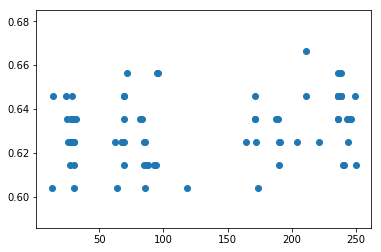

In [132]:
scatter(best_locs, best_scores)

In [117]:
i+len(search_ascii)

350